Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


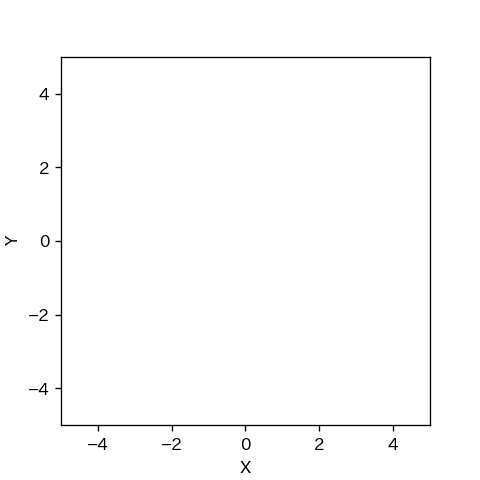

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_trap_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0 真値: [2.75237516 3.30624986 2.97713605] 推定値: [2.58891437 4.08640658 4.19720533] 誤差: 0.7970971907816633
1
1 真値: [ 2.10053138 -2.54862171  1.80974573] 推定値: [6.569208   0.12329851 2.85089874] 誤差: 5.206556284724986
2 真値: [-0.58244466  5.0916745   2.4823534 ] 推定値: [-1.11394957  0.9968262   3.78136356] 誤差: 4.129198482197703
3 真値: [-0.38327699 -6.18514325  0.17765182] 推定値: [ 4.76210392e+00 -1.29231968e-03 -2.98304344e+00] 誤差: 8.04456071397079
4 真値: [-3.64954845  2.92567798  5.59106528] 推定値: [-3.79482177  3.041661    5.90041138] 誤差: 0.1858935034129779
2
5 真値: [-4.64651887  3.23559142 -0.81125959] 推定値: [-2.6075695   2.13180118 -2.72001596] 誤差: 2.318548555554785
6 真値: [2.02919931 1.52970437 0.47998348] 推定値: [1.91415438 1.63241452 0.41971531] 誤差: 0.1542229243524737
3
7 真値: [-2.01800047 -1.55618763  2.3160884 ] 推定値: [-2.58136349 -1.56269917  2.2031416 ] 誤差: 0.5634006553554398
4
8 真値: [1.70769723 0.4902396  2.79826865] 推定値: [1.29139445 1.20642078 2.99809733] 誤差: 0.8283860671723766
5
9 真値: [0.13409

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [4.8688204  4.3474084  1.18167398] 推定値: [3.55452468 3.09874957 3.64513088] 誤差: 1.812876742175325
21 真値: [-5.41986448 -3.43434425  4.44442073] 推定値: [2.07877083 1.94963322 0.56293868] 誤差: 9.231291610695017
22 真値: [-2.84482115  1.97582421 -0.01460641] 推定値: [-3.03670611  4.79801745 -0.52745153] 誤差: 2.828708984793352
23 真値: [ 1.15677286 -2.32335464  1.60878383] 推定値: [ 8.4868338   5.80099871 -2.29902083] 誤差: 10.942344851384213
24 真値: [5.53484379 2.49905804 2.28971945] 推定値: [0.75708857 1.11444307 0.07897905] 誤差: 4.974344536326841
25 真値: [-0.21671524  2.46532641  4.89017175] 推定値: [ 7.92319896 -3.33604849  2.86180774] 誤差: 9.995706772315536
26 真値: [-0.52197298  5.36403983  4.40602191] 推定値: [-6.56538287 -0.71361729  1.32190568] 誤差: 8.570922894487737
27 真値: [-1.58326719  3.40925018  2.83444495] 推定値: [-1.65464587 -0.05658355  1.65677998] 誤差: 3.466568670554671
28 真値: [ 2.74523126 -1.04472008  5.54190342] 推定値: [ 2.28654516 -0.61631178  7.555765  ] 誤差: 0.6276357221222092
12
29 真値: [ 0.73245274 